In [1]:
import pandas as pd
# 형태소 분석기
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer

# 필요한것 import 
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

# 데이터 확인

In [2]:
train_df = pd.read_csv("./data/nsmc/ratings_train.txt", sep="\t")
test_df = pd.read_csv("./data/nsmc/ratings_test.txt", sep ="\t")

In [3]:
train_df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
# shape 보기
train_df.shape, test_df.shape

((150000, 3), (50000, 3))

In [5]:
train_df.isna().sum()

id          0
document    5
label       0
dtype: int64

## 결측치 제거

In [6]:
train_df = train_df.dropna()
test_df = test_df.dropna()

In [7]:
train_df.shape, test_df.shape

((149995, 3), (49997, 3))

## 종속변수 확인

In [8]:
train_df["label"].value_counts()

label
0    75170
1    74825
Name: count, dtype: int64

# 전처리 (예시)

In [9]:
# 한글 이외의 문자들 제거
# regex 정규표현식을 사용하겠다
# ^ not : 한글 자음 모음,  조합 등등 제외해서 삭제해라~~
# " "띄어쓰기로 치환하는것도 방법
train_df["document"] = train_df["document"].str.replace("[^ㄱ-ㅎ가-힣ㅏ-ㅣ ]", " ", regex = True) 
test_df["document"] = test_df["document"].str.replace("[^ㄱ-ㅎ가-힣ㅏ-ㅣ ]", " ", regex = True)

In [10]:
train_df.tail()

,id,document,label
149995,6222902,인간이 문제지 소는 뭔죄인가,0
149996,8549745,평점이 너무 낮아서,1
149997,9311800,이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다,0
149998,2376369,청춘 영화의 최고봉 방황과 우울했던 날들의 자화상,1
149999,9619869,한국 영화 최초로 수간하는 내용이 담긴 영화,0


## 없어져 버린 내용 제거

In [11]:
train_df = train_df[train_df["document"].map(lambda x : len(x.strip()) >= 5)]
test_df = test_df[test_df["document"].map(lambda x : len(x.strip()) >= 5)]

In [12]:
train_df.shape, test_df.shape

((142975, 3), (47779, 3))

# 중복 데이터 확인 (짜침)

In [13]:
train_df[train_df["document"].duplicated(keep=False)].sort_values("document")

,id,document,label
43436,9582856,그리고 내 감정을 불러 일으켰다,1
46599,9682597,그리고 내 감정을 불러 일으켰다,1
123713,9582855,그리고 내 감정을 불러 일으켰다,1
138373,171407,가입 추천바람,1
93364,171409,가입 추천바람,1
...,...,...,...
12049,8671349,허술한 이야기에 액션마저 허접하군,0
6064,9488717,홍진호가 최고여야 하고 홍진호만 우승해야 한다고 주장하는 콩빠들 극혐,0
52284,9488714,홍진호가 최고여야 하고 홍진호만 우승해야 한다고 주장하는 콩빠들 극혐,1
8446,5158304,힐러리 더프의 매력에 빠지다,1


In [14]:
# 중복 데이터 제거
train_df = train_df.drop_duplicates(subset=["document"])
test_df = test_df.drop_duplicates(subset=["document"])

In [15]:
train_df.shape, test_df.shape

((141812, 3), (47576, 3))

## 문장을 토큰으로 쪼개야함~~!!
- 형태소 분석기를 쓰는게 기본이다.

# 토큰화 (okt 를 사용하면 그나마 빠르다)

In [16]:
okt = Okt() 

# 원래 이름은 트위터다 
# 신조어에 대한 대응이 편하다, 언어 습관을 분석하는 용도로 만들어짐

In [75]:
okt.morphs("아 더빙 개빡치네요 목소리")

['아', '더빙', '개', '빡치네요', '목소리']

### 어간추출

In [76]:
okt.morphs("아 더빙 개빡치네요 목소리", stem = True)

['아', '더빙', '개', '빡치다', '목소리']

### 명사추출

In [42]:
okt.nouns("아 더빙 개빡치네요 목소리")

['더빙', '개', '목소리']

### 품사 태그하기

In [79]:
okt.pos("아 더빙 개빡치네요 목소리")[1]

('더빙', 'Noun')

In [58]:
okt.phrases("아 더빙 개빡치네요 목소리")

['더빙', '더빙 개', '목소리']

# 단어만 추출하면 어찌될까?

In [21]:
# %%time
# train_df["token"] = train_df["document"].map(lambda x : okt.morphs(x, stem = True))
# test_df["token"] = test_df["document"].map(lambda x : okt.morphs(x, stem = True))

# 명사만 추출해보자

In [17]:
%%time
train_df["token"] = train_df["document"].map(lambda x : okt.nouns(x))
test_df["token"] = test_df["document"].map(lambda x : okt.nouns(x))

CPU times: total: 8min 28s
Wall time: 8min 17s


### 단어로 저장한것

In [ ]:
# train_df.to_csv("./data/nsmc_ratings_train_pre.csv", index = False)
# test_df.to_csv("./data/nsmc_ratings_test_pre.csv", index = False)

In [81]:
# train_df = pd.read_csv("./data/nsmc_ratings_train_pre.csv", index_col=False)
# test_df = pd.read_csv("./data/nsmc_ratings_test_pre.csv", index_col=False)

### 명사로 저장한것

In [18]:
train_df.to_csv("./data/nsmc_ratings_train_pre2.csv", index = False)
test_df.to_csv("./data/nsmc_ratings_test_pre2.csv", index = False)

In [19]:
train_df = pd.read_csv("./data/nsmc_ratings_train_pre2.csv", index_col=False)
test_df = pd.read_csv("./data/nsmc_ratings_test_pre2.csv", index_col=False)

In [20]:
train_df.head()

,id,document,label,token
0,9976970,아 더빙 진짜 짜증나네요 목소리,0,"['더빙', '진짜', '목소리']"
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1,"['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기']"
2,10265843,너무재밓었다그래서보는것을추천한다,0,"['무재', '밓었', '다그', '래서', '추천']"
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0,"['교도소', '이야기', '구먼', '재미', '평점', '조정']"
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,"['몬페', '의', '연기', '영화', '스파이더맨', '커스틴', '던스트']"


In [83]:
test_df.head()

,id,document,label,token
0,6270596,굳 ㅋ,1,"['굳다', 'ㅋ']"
1,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0,"['뭐', '야', '이', '평점', '들', '은', '나쁘다', '않다', '..."
2,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0,"['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기..."
3,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0,"['만', '아니다', '별', '다섯', '개', '주다', '왜', '로', '..."
4,7898805,음악이 주가 된 최고의 음악영화,1,"['음악', '이', '주가', '되다', '최고', '의', '음악', '영화']"


## 혹시나 토큰에 들어간 애들중 없는 애들 알아보기

In [21]:
train_df[train_df["token"].map(lambda x :len (x) < 1)]

,id,document,label,token


In [22]:
test_df[test_df["token"].map(lambda x :len (x) < 1)]

,id,document,label,token


# 문장이 5개 이상인 애들만

In [23]:
train_df = train_df[train_df["token"].map(lambda x :len (x) >= 5)]
test_df = test_df[test_df["token"].map(lambda x :len (x) >= 5)]

- 없다

# 정수인코딩

In [24]:
tokenizer = Tokenizer(num_words = 10000)

In [25]:
# 단어 집합 생성
# 등장 빈도 수가 높은 순서대로 정수값 부여
tokenizer.fit_on_texts(train_df["token"])

In [26]:
# 단어 집합
word_index = tokenizer.word_index

In [27]:
len(word_index.keys())

38569

# 바뀐 단어 확인

In [28]:
idx2word = { 0:"<PAD>", 1:"<s>", 2:"<UNK>" }
idx2word.update({
    # +3 안겹치기 위해서 
    value + 3 : key for key, value in word_index.items()
})
idx2word

{0: '<PAD>',
 1: '<s>',
 2: '<UNK>',
 4: "'영화'",
 5: "'정말'",
 6: "'진짜'",
 7: "'이'",
 8: "'점'",
 9: "'연기'",
 10: "'것'",
 11: "'평점'",
 12: "'최고'",
 13: "'스토리'",
 14: "'생각'",
 15: "'왜'",
 16: "'드라마'",
 17: "'사람'",
 18: "'감동'",
 19: "'보고'",
 20: "'말'",
 21: "'더'",
 22: "'때'",
 23: "'배우'",
 24: "'내'",
 25: "'거'",
 26: "'감독'",
 27: "'내용'",
 28: "'시간'",
 29: "'재미'",
 30: "'그냥'",
 31: "'뭐'",
 32: "'그'",
 33: "'좀'",
 34: "'쓰레기'",
 35: "'수'",
 36: "'나'",
 37: "'작품'",
 38: "'사랑'",
 39: "'다시'",
 40: "'하나'",
 41: "'마지막'",
 42: "'볼'",
 43: "'이건'",
 44: "'정도'",
 45: "'완전'",
 46: "'처음'",
 47: "'장면'",
 48: "'액션'",
 49: "'주인공'",
 50: "'걸'",
 51: "'지금'",
 52: "'돈'",
 53: "'이야기'",
 54: "'최악'",
 55: "'느낌'",
 56: "'임'",
 57: "'연출'",
 58: "'끝'",
 59: "'개'",
 60: "'듯'",
 61: "'년'",
 62: "'명작'",
 63: "'역시'",
 64: "'별로'",
 65: "'이해'",
 66: "'안'",
 67: "'이영화'",
 68: "'또'",
 69: "'여자'",
 70: "'때문'",
 71: "'분'",
 72: "'난'",
 73: "'중'",
 74: "'꼭'",
 75: "'편'",
 76: "'보기'",
 77: "'기억'",
 78: "'결말'",
 79: "'마음'",
 80

In [93]:
# 단어 등장 수
#tokenizer.word_counts

In [94]:
# 토큰화된거 종류
len(tokenizer.word_counts)

43140

In [29]:
# 토큰화
x_train = tokenizer.texts_to_sequences(train_df["token"])
x_test = tokenizer.texts_to_sequences(test_df["token"])

In [102]:
" ".join(map(lambda x : idx2word[x], x_train[1]))

"'결혼' '배우다' '게' '어렵다' <UNK> '멋지다' '짝' '않다' '타임' '몇번' '로'"

## 독립변수 설정하기
- 길이가 다 다르기 때문에 numpy 배열에 넣기 좀 거시기 하다

In [30]:
x_train = np.array(x_train, dtype=object)
x_test = np.array(x_test, dtype=object)

In [31]:
print(x_train.shape)
print(x_test.shape)

(139490,)
(46754,)


In [106]:
x_train.ndim, x_test.ndim

(1, 1)

- 1차원 배열로 일단 만들었다

## 종속변수 설정하기

In [32]:
train_df.dtypes

id           int64
document    object
label        int64
token       object
dtype: object

In [33]:
y_train = train_df["label"].to_numpy()
y_test = test_df["label"].to_numpy()

In [34]:
print(y_test)
print(len(y_test))

[0 0 0 ... 0 0 0]
46754


In [35]:
# 이진 분류 모델을 쓰면 되것네여~~

### 데이터 분석해보기
- 적정 words_num 과 maxlen 구하기

In [36]:
# 문장 길이 분석
lengths = np.array([len(x) for x in x_train])

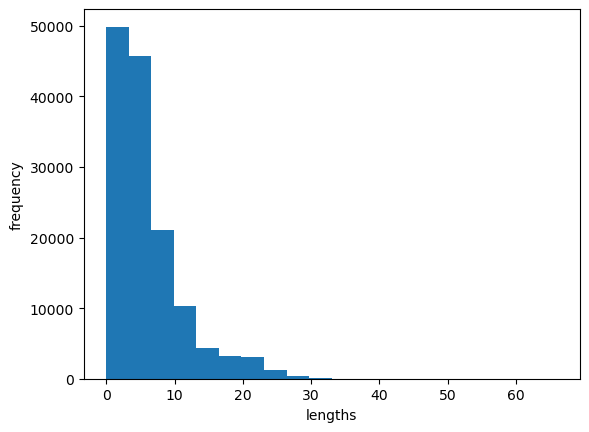

In [37]:
plt.figure()

plt.hist(lengths, bins = 20)

plt.xlabel("lengths")
plt.ylabel("frequency")
plt.show()

# 테스트 데이터에 대한 lengths

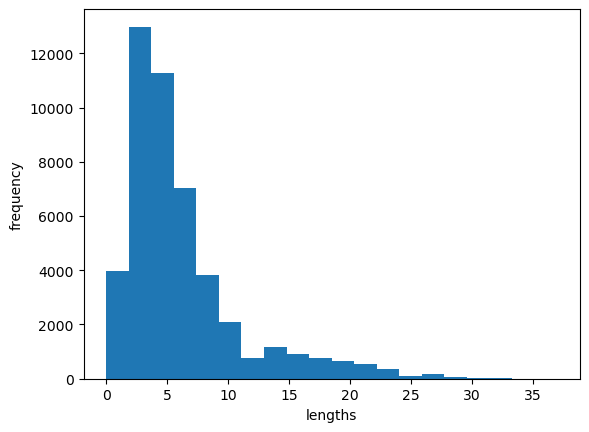

In [38]:
lengths = np.array([len(x) for x in x_test])


plt.figure()

plt.hist(lengths, bins = 20)

plt.xlabel("lengths")
plt.ylabel("frequency")
plt.show()

- 0 ~ 20 단어가 몰려 있음 maxlen 으로 30개 정도면 충분해 보임

In [39]:
np.mean(lengths), np.min(lengths), np.max(lengths), np.median(lengths)

(np.float64(6.028724814989092), np.int64(0), np.int64(37), np.float64(5.0))

In [40]:
np.quantile(lengths, [0.25, 0.5, 0.75])

array([3., 5., 7.])

# 데이터 분할

## 독립변수와 종속변수를 나눠야함

### Embedding 을 위한 데이터 자르기

In [41]:
x_train.shape, y_train.shape

((139490,), (139490,))

In [42]:
x_test.shape, y_test.shape

((46754,), (46754,))

- 145059 개의 train data 가 있습니다~ 

In [43]:
x_sub, x_val, y_sub, y_val = train_test_split(
    x_train,
    y_train, 
    test_size = 0.2,
    stratify= y_train,
    random_state = 34
)

In [44]:
x_sub.shape, x_val.shape

((111592,), (27898,))

## 변태 그리스 아저씨? 기법 이용하기

In [45]:
sub_seq = pad_sequences(x_sub, maxlen = 20, padding="post",truncating='post')
val_seq = pad_sequences(x_val, maxlen = 20, padding="post",truncating='post')
test_seq = pad_sequences(x_test, maxlen = 20, padding="post",truncating='post')

In [46]:
sub_seq.shape, val_seq.shape, test_seq.shape

((111592, 20), (27898, 20), (46754, 20))

In [47]:
sub_seq[1]

array([  2,   1, 168,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [48]:
model = keras.Sequential()
model.add(keras.Input(shape = (15,)))

# 10000개의 단어를 256개로 늘릴것이다
model.add(keras.layers.Embedding(10000, 128)) # 128개의 특성으로 표현해줄께
model.add(keras.layers.Dropout(0.2)) # 모델 복잡해지니까 ~

# conv1d 로 좍좍~ 3번 레이어링 해주셈
model.add(keras.layers.Conv1D(256, 5, activation="swish"))
model.add(keras.layers.Dense(128))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.MaxPooling1D(2))

model.add(keras.layers.Conv1D(128, 5, activation="swish"))
model.add(keras.layers.Dense(64))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.MaxPooling1D(2))


model.add(keras.layers.GRU(16, dropout = 0.3))

model.add(keras.layers.Dense(100, activation="swish"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [49]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 20, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 16, 256)             │         164,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16, 256)             │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 10, 128)             │         229,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10, 128)             │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 10, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │          12,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,902,025 (7.26 MB)

 Trainable params: 1,901,257 (7.25 MB)

 Non-trainable params: 768 (3.00 KB)

In [50]:
rmsprop = keras.optimizers.RMSprop(learning_rate= 1e-4)
model.compile(
    optimizer= "adam", 
    #optimizer= rmsprop, # 너무 버려지는게 많아요
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

es_cb = keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True, monitor='val_loss')

history = model.fit(
    sub_seq, 
    y_sub, 
    epochs = 100,
    batch_size = 64, 
    validation_data = (val_seq, y_val), 
    callbacks = [es_cb]
)

Epoch 1/100
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 65s 35ms/step - accuracy: 0.7337 - loss: 0.5196 - val_accuracy: 0.7680 - val_loss: 0.4800
Epoch 2/100
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 59s 34ms/step - accuracy: 0.7873 - loss: 0.4450 - val_accuracy: 0.7675 - val_loss: 0.4743
Epoch 3/100
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 59s 34ms/step - accuracy: 0.8072 - loss: 0.4109 - val_accuracy: 0.7647 - val_loss: 0.4880
Epoch 4/100
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 59s 34ms/step - accuracy: 0.8248 - loss: 0.3785 - val_accuracy: 0.7621 - val_loss: 0.5263
Epoch 5/100
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 60s 35ms/step - accuracy: 0.8377 - loss: 0.3514 - val_accuracy: 0.7541 - val_loss: 0.5307
Epoch 6/100
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 61s 35ms/step - accuracy: 0.8516 - loss: 0.3285 - val_accuracy: 0.7519 - val_loss: 0.5772


In [51]:
model.evaluate(test_seq, y_test)

1462/1462 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7692 - loss: 0.4724


[0.4724048972129822, 0.7691748142242432]

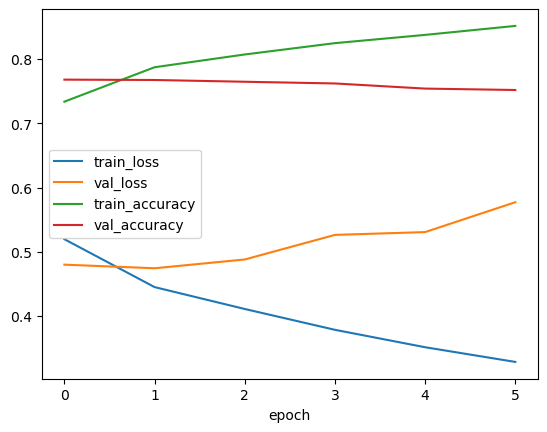

In [52]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["val_loss"], label = "val_loss")

plt.plot(history.history["accuracy"], label = "train_accuracy")
plt.plot(history.history["val_accuracy"], label = "val_accuracy")

plt.legend()
plt.xlabel("epoch")
plt.show()

# 1차 시도
- 특성 모두 모두
- 과대적합 모델 완성!
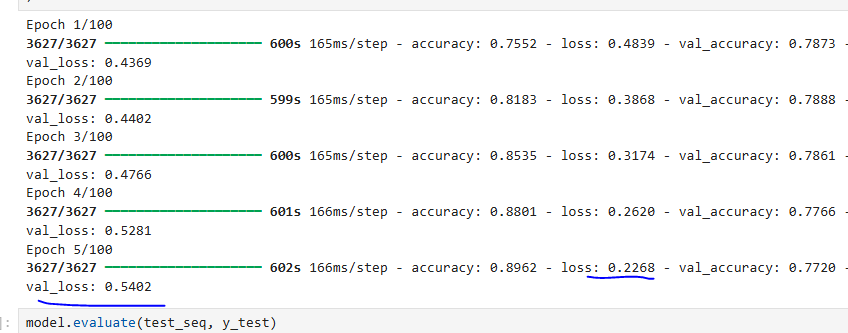

# 2차 시도
- dropout 을 중간중간 추가해주고
- 필터수를 좀 늘려봤음

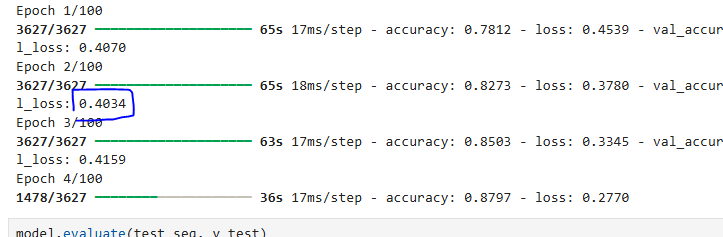

# 3차 시도
- padding 뒤에다가 넣고 dense layer 추가요

![image.png](attachment:4b0f2d3e-081e-4fab-85d2-6fb63aa640b4.png)

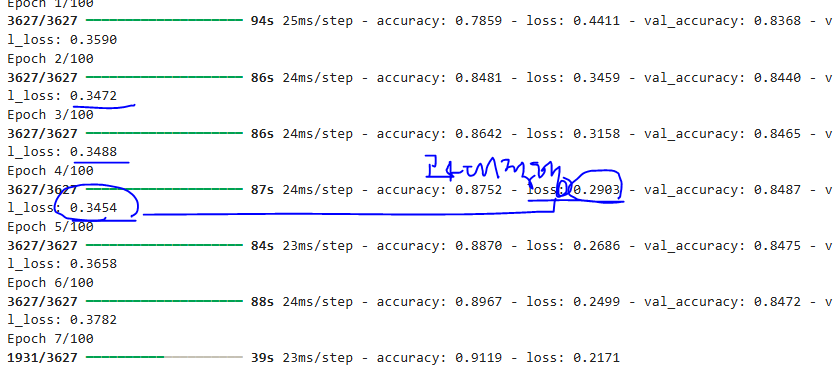